In [3]:
import sys
print(sys.executable)


D:\anaconda3\envs\catalyst39\python.exe


In [4]:
import pandas as pd
from rdkit import Chem
import torch
from rxnmapper import RXNMapper


In [6]:
import pandas as pd
from rdkit import Chem
import torch
from torch_geometric.data import Data

# ✅ Load filtered dataset (with confidence ≥ 0.5)
df = pd.read_parquet(r"C:\Users\Akshith Varma\Downloads\Catalyst\all_mapped_reactions_combined.parquet")
df = df[df['Confidence'] >= 0.5]

def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    edge_index = []

    for atom in mol.GetAtoms():
        atom_features.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            atom.GetIsAromatic()
        ])

    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.append((start, end))
        edge_index.append((end, start))  # bidirectional

    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)

# Split mapped reaction into reactants and products
df[['Mapped_Reactants', 'Mapped_Products']] = df['Mapped_Reaction'].str.split('>>', expand=True)

print("🧪 Sample:\n", df[['Mapped_Reactants', 'Mapped_Products', 'Catalyst']].head())


🧪 Sample:
                                     Mapped_Reactants  \
0  [CH3:1][C:2]([CH3:3])([CH3:4])[c:5]1[cH:6][cH:...   
1  [CH3:1][CH:2]([CH3:3])[c:4]1[cH:5][cH:6][cH:7]...   
2  [CH3:1][CH:2]([CH3:3])[c:5]1[cH:6][cH:7][c:8](...   
3  [CH3:1][CH:2]([CH3:3])[c:5]1[cH:6][cH:7][c:8](...   
4  [CH3:1][CH:2]([CH3:3])[c:5]1[cH:6][cH:7][c:8](...   

                                     Mapped_Products  \
0  [CH3:1][C:2]([CH3:3])([CH3:4])[CH:5]1[CH2:6][C...   
1  [CH3:1][CH:2]([CH3:3])[c:4]1[cH:5][cH:6][c:7](...   
2  [CH3:1][C:2]([CH3:3])([Br:4])[c:5]1[cH:6][cH:7...   
3  [CH3:1][C:2]([CH3:3])([Br:4])[c:5]1[cH:6][cH:7...   
4  [CH3:1][C:2]([CH3:3])([Br:4])[c:5]1[cH:6][cH:7...   

                                  Catalyst  
0                                     [Ni]  
1                                  C(Cl)Cl  
2                          C(Cl)(Cl)(Cl)Cl  
3  C(Cl)(Cl)(Cl)Cl.CC(N=NC(C#N)(C)C)(C#N)C  
4                                C(Cl)Cl.O  


In [9]:
df = df.reset_index(drop=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
catalyst_labels = label_encoder.fit_transform(df['Catalyst'])


In [11]:
from torch_geometric.data import Data

graph_data = []
skipped = 0

for i, row in df.iterrows():
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])

    if react_graph is None or prod_graph is None:
        skipped += 1
        continue

    # Offset product node indices
    prod_graph.edge_index += react_graph.x.size(0)

    # Combine both graphs
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)
    y = torch.tensor([catalyst_labels[i]], dtype=torch.long)

    graph_data.append(Data(x=x, edge_index=edge_index, y=y))

print(f"✅ Final graph samples: {len(graph_data)}, Skipped: {skipped}")
print("🔢 Number of catalyst classes:", num_classes)


✅ Final graph samples: 355860, Skipped: 1
🔢 Number of catalyst classes: 886


In [12]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Split the graph data
train_data, val_data = train_test_split(graph_data, test_size=0.1, random_state=42)

# Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

print(f"🧪 Training samples: {len(train_data)}, Validation samples: {len(val_data)}")


🧪 Training samples: 320274, Validation samples: 35586


In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class CatalystGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(CatalystGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [14]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatalystGNN(
    in_channels=train_data[0].x.shape[1],
    hidden_channels=128,
    num_classes=num_classes
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [15]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total


📚 Epoch 01, Loss: 4.3878, Val Acc: 0.1509
✅ New best model saved.
📚 Epoch 02, Loss: 4.1462, Val Acc: 0.1658
✅ New best model saved.
📚 Epoch 03, Loss: 4.0435, Val Acc: 0.1766
✅ New best model saved.
📚 Epoch 04, Loss: 3.9736, Val Acc: 0.1823
✅ New best model saved.
📚 Epoch 05, Loss: 3.9201, Val Acc: 0.1853
✅ New best model saved.
📚 Epoch 06, Loss: 3.8763, Val Acc: 0.1927
✅ New best model saved.
📚 Epoch 07, Loss: 3.8397, Val Acc: 0.1980
✅ New best model saved.
📚 Epoch 08, Loss: 3.8066, Val Acc: 0.2009
✅ New best model saved.
📚 Epoch 09, Loss: 3.7777, Val Acc: 0.2040
✅ New best model saved.
📚 Epoch 10, Loss: 3.7498, Val Acc: 0.2091
✅ New best model saved.
📚 Epoch 11, Loss: 3.7255, Val Acc: 0.2116
✅ New best model saved.
📚 Epoch 12, Loss: 3.7039, Val Acc: 0.2095
📚 Epoch 13, Loss: 3.6849, Val Acc: 0.2079
📚 Epoch 14, Loss: 3.6668, Val Acc: 0.2160
✅ New best model saved.
📚 Epoch 15, Loss: 3.6507, Val Acc: 0.2162
✅ New best model saved.
📚 Epoch 16, Loss: 3.6368, Val Acc: 0.2216
✅ New best model

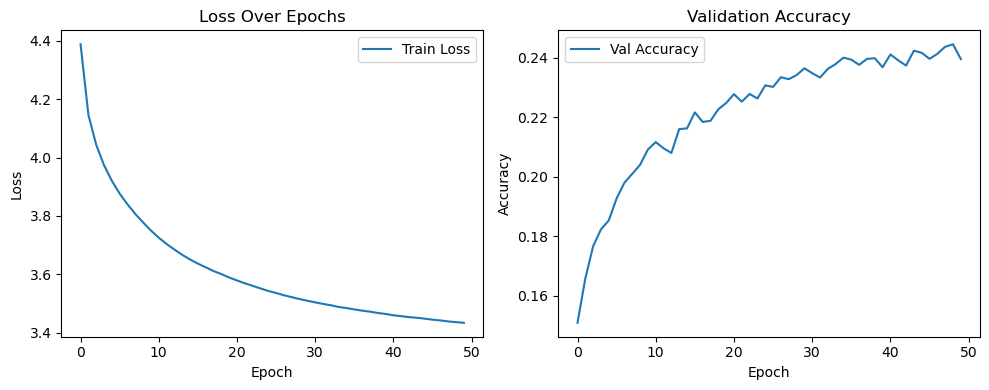

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import matplotlib.pyplot as plt

# ✅ Model Definition
class CatalystGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(CatalystGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

# ✅ Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatalystGNN(in_channels=graph_data[0].x.shape[1], hidden_channels=128, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ✅ Data split and loaders
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(graph_data, test_size=0.1, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# ✅ Train / Eval Functions
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)
    return correct / total

# ✅ Main Loop with Early Stopping
best_acc = 0
wait = 0
patience = 7
train_losses = []
val_accuracies = []

for epoch in range(1, 51):
    loss = train()
    acc = evaluate(val_loader)
    train_losses.append(loss)
    val_accuracies.append(acc)
    
    print(f"📚 Epoch {epoch:02d}, Loss: {loss:.4f}, Val Acc: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        wait = 0
        torch.save(model.state_dict(), "best_gnn_model.pt")
        print("✅ New best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("🛑 Early stopping triggered.")
            break

# ✅ Optional Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import top_k_accuracy_score

def evaluate_topk(loader, k):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            all_preds.append(out)
            all_labels.append(data.y)

    preds = torch.cat(all_preds).cpu()
    labels = torch.cat(all_labels).cpu()

    # ✅ Fix: Use all label indices [0, 1, ..., 885]
    all_possible_labels = list(range(num_classes))
    
    return top_k_accuracy_score(labels, preds, k=k, labels=all_possible_labels)


In [19]:
print("🎯 Top-3 Accuracy:", evaluate_topk(val_loader, k=3))
print("🎯 Top-5 Accuracy:", evaluate_topk(val_loader, k=5))


🎯 Top-3 Accuracy: 0.43916146799303096
🎯 Top-5 Accuracy: 0.5330467037599056


In [23]:
# --- 1. Import dependencies ---
import pandas as pd
import torch
from rdkit import Chem
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import top_k_accuracy_score

# --- 2. Load dataset ---
df = pd.read_csv(r"C:\Users\Akshith Varma\Downloads\Catalyst\all_mapped_reactions_combined.csv")  # Change path if needed
df = df[df['Confidence'] >= 0.5].reset_index(drop=True)

# --- 3. Extract mapped reactants and products ---
df[['Mapped_Reactants', 'Mapped_Products']] = df['Mapped_Reaction'].str.split('>>', expand=True)

# --- 4. Define SMILES → Graph conversion ---
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_feats = []
    edge_index = []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])

    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.append((start, end))
        edge_index.append((end, start))

    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

# --- 5. Encode catalyst labels ---
label_encoder = LabelEncoder()
catalyst_labels = label_encoder.fit_transform(df['Catalyst'])
num_classes = len(label_encoder.classes_)

# --- 6. Create graph data ---
graph_data = []
skipped = 0

for i, row in df.iterrows():
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])
    if react_graph is None or prod_graph is None:
        skipped += 1
        continue

    prod_graph.edge_index += react_graph.x.size(0)
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)
    y = torch.tensor([catalyst_labels[i]], dtype=torch.long)

    graph_data.append(Data(x=x, edge_index=edge_index, y=y))

print(f"✅ Final graph samples: {len(graph_data)}, Skipped: {skipped}")
print("🔢 Number of catalyst classes:", num_classes)

# --- 7. Train-test split ---
train_data, val_data = train_test_split(graph_data, test_size=0.1, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# --- 8. Define GNN Model ---
class CatalystGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# --- 9. Setup Training ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatalystGNN(train_data[0].x.size(1), 128, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# --- 10. Train and Evaluate ---
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total

best_acc = 0
for epoch in range(1, 51):
    loss = train()
    acc = evaluate(val_loader)
    print(f"📚 Epoch {epoch:02d}, Loss: {loss:.4f}, Val Acc: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_catalyst_gnn.pt")
        print("✅ New best model saved.")

# --- 11. Top-k Evaluation ---
def evaluate_topk(loader, k=3):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            all_preds.append(out)
            all_labels.append(data.y)
    preds = torch.cat(all_preds).cpu()
    labels = torch.cat(all_labels).cpu()
    return top_k_accuracy_score(labels, preds, k=k, labels=list(range(num_classes)))

print("🎯 Top-3 Accuracy:", evaluate_topk(val_loader, k=3))
print("🎯 Top-5 Accuracy:", evaluate_topk(val_loader, k=5))


✅ Final graph samples: 355860, Skipped: 1
🔢 Number of catalyst classes: 886
📚 Epoch 01, Loss: 4.3887, Val Acc: 0.1518
✅ New best model saved.
📚 Epoch 02, Loss: 4.1478, Val Acc: 0.1621
✅ New best model saved.
📚 Epoch 03, Loss: 4.0510, Val Acc: 0.1716
✅ New best model saved.
📚 Epoch 04, Loss: 3.9856, Val Acc: 0.1796
✅ New best model saved.
📚 Epoch 05, Loss: 3.9348, Val Acc: 0.1853
✅ New best model saved.
📚 Epoch 06, Loss: 3.8910, Val Acc: 0.1921
✅ New best model saved.
📚 Epoch 07, Loss: 3.8519, Val Acc: 0.1941
✅ New best model saved.
📚 Epoch 08, Loss: 3.8181, Val Acc: 0.2008
✅ New best model saved.
📚 Epoch 09, Loss: 3.7885, Val Acc: 0.2046
✅ New best model saved.
📚 Epoch 10, Loss: 3.7617, Val Acc: 0.2037
📚 Epoch 11, Loss: 3.7393, Val Acc: 0.2051
✅ New best model saved.
📚 Epoch 12, Loss: 3.7182, Val Acc: 0.2045
📚 Epoch 13, Loss: 3.7000, Val Acc: 0.2099
✅ New best model saved.
📚 Epoch 14, Loss: 3.6823, Val Acc: 0.2071
📚 Epoch 15, Loss: 3.6670, Val Acc: 0.2133
✅ New best model saved.
📚 Epoc

In [57]:
#react_smiles = "CC(C)OC(=O)C1=CC=CC=C1"  # Reactant
#prod_smiles = "CC(C)OC1=CC=CC=C1"        # Product
#react_smiles = "C1=CC=CN=C1C(=O)Cl"   # Pyridine acyl chloride
#prod_smiles = "C1=CC=CN=C1C(=O)OC"    # Methyl ester of pyridine carboxylic acid
react_smiles = "[Cl-].[Al+3].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][CH2:8][C:9](Cl)=[O:10].[C:12]1([CH:18]([CH3:20])[CH3:19])[CH:17]=[CH:16][CH:15]=[CH:14][CH:13]=1"   # Pyridine acyl chloride
prod_smiles = "[Cl:5][CH2:6][CH2:7][CH2:8][C:9]([C:15]1[CH:16]=[CH:17][C:12]([CH:18]([CH3:20])[CH3:19])=[CH:13][CH:14]=1)=[O:10]"




In [66]:
# Convert SMILES to graph data
react_graph = mol_to_graph(react_smiles)
prod_graph = mol_to_graph(prod_smiles)

# Offset indices
prod_graph.edge_index += react_graph.x.size(0)

# Combine features and edges
x = torch.cat([react_graph.x, prod_graph.x], dim=0)
edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

# Create PyG Data object
test_data = Data(x=x, edge_index=edge_index)
test_data.batch = torch.zeros(x.size(0), dtype=torch.long)
test_data = test_data.to(device)

# Predict
model.eval()
with torch.no_grad():
    out = model(test_data)
    topk = out.softmax(dim=1).topk(5)

top_preds = label_encoder.inverse_transform(topk.indices[0].cpu().numpy())
confidences = topk.values[0].cpu().numpy()

# Show result
print("🧪 Predicted Catalysts:")
for i in range(len(top_preds)):
    print(f"{i+1}. {top_preds[i]} (confidence: {confidences[i]:.4f})")


🧪 Predicted Catalysts:
1. CO.[Pd] (confidence: 0.0663)
2. C1COCC1 (confidence: 0.0339)
3. CO.[Ni] (confidence: 0.0322)
4. C(O)C.[Pd] (confidence: 0.0302)
5. CN(C=O)C (confidence: 0.0266)


In [41]:
import torch
from rdkit import Chem
import random
from sklearn.metrics import accuracy_score

# Make sure model is in eval mode
model.eval()

# Pick random N samples from your original DataFrame
N = 100  # you can increase this to 50 or 100
sample_indices = random.sample(range(len(df)), N)

correct_top1 = 0
correct_top3 = 0
correct_top5 = 0

print(f"\n🎯 Evaluating {N} random samples:\n")

for idx in sample_indices:
    row = df.iloc[idx]
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])
    actual = row['Catalyst']

    if react_graph is None or prod_graph is None:
        print(f"⛔ Skipped index {idx} due to invalid graph.")
        continue

    prod_graph.edge_index += react_graph.x.size(0)
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

    test_data = Data(x=x, edge_index=edge_index)
    test_data.batch = torch.zeros(x.size(0), dtype=torch.long)
    test_data = test_data.to(device)

    with torch.no_grad():
        out = model(test_data)
        probs = out.softmax(dim=1).squeeze()
        topk = probs.topk(5)
        top_preds = label_encoder.inverse_transform(topk.indices.cpu())

    # Match checks
    top1 = top_preds[0]
    if actual == top1:
        correct_top1 += 1
    if actual in top_preds[:3]:
        correct_top3 += 1
    if actual in top_preds:
        correct_top5 += 1

    print(f"🧪 Sample {idx}")
    print(f"🔍 Predicted Top-5: {list(top_preds)}")
    print(f"✅ Actual Catalyst: {actual}")
    print(f"🎯 Match: {'✅ YES' if actual in top_preds else '❌ NO'}\n")

# Summary
print("✅ Batch Prediction Summary:")
print(f"🔹 Top-1 Accuracy: {correct_top1 / N:.2f}")
print(f"🔹 Top-3 Accuracy: {correct_top3 / N:.2f}")
print(f"🔹 Top-5 Accuracy: {correct_top5 / N:.2f}")



🎯 Evaluating 100 random samples:

🧪 Sample 287792
🔍 Predicted Top-5: ['CN(C=O)C', 'CN(C)C=O', 'C1COCC1', 'O1CCCC1', 'CS(C)=O']
✅ Actual Catalyst: CN(C=O)C
🎯 Match: ✅ YES

🧪 Sample 152272
🔍 Predicted Top-5: ['O1CCCC1', 'C1COCC1', 'C1COCC1.C(OCC)C', 'C1COCC1.[Cu]I', 'C1COCC1.C(OCC)(=O)C']
✅ Actual Catalyst: C(OCC)C
🎯 Match: ❌ NO

🧪 Sample 261959
🔍 Predicted Top-5: ['C(Cl)Cl', 'O', 'ClCCl', 'C(Cl)(Cl)Cl', 'C(#N)C']
✅ Actual Catalyst: C(Cl)Cl
🎯 Match: ✅ YES

🧪 Sample 35800
🔍 Predicted Top-5: ['CN(C=O)C', 'CN(C)C=O', 'CS(C)=O', 'C1COCC1', 'O1CCCC1']
✅ Actual Catalyst: CN(C=O)C
🎯 Match: ✅ YES

🧪 Sample 117154
🔍 Predicted Top-5: ['C(Cl)(Cl)(Cl)Cl', 'C(O)(=O)C', 'C(Cl)Cl', 'C1COCC1', 'CN(C=O)C']
✅ Actual Catalyst: C(Cl)(Cl)(Cl)Cl
🎯 Match: ✅ YES

🧪 Sample 106820
🔍 Predicted Top-5: ['C1C=CC([P]([Pd]([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)[P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)=CC=1.C(O)C', 'C(COC)OC.O.C1C=CC([P]([Pd]([P](C2C

In [65]:
from rdkit import Chem
from torch_geometric.data import Data
import torch

# Helper function to convert SMILES to graph (simplified)
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_feats = []
    edge_index = []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])

    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.append((start, end))
        edge_index.append((end, start))

    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)




# Custom rare reaction
react_smiles = "[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7][CH:6]=1)([CH3:4])([CH3:3])[CH3:2]"
prod_smiles  = "[C:1]([CH:5]1[CH2:6][CH2:7][CH:8]([OH:11])[CH2:9][CH2:10]1)([CH3:4])([CH3:2])[CH3:3]"

# Convert to graphs
react_graph = mol_to_graph(react_smiles)
prod_graph = mol_to_graph(prod_smiles)

# Make sure conversion succeeded
if react_graph is None or prod_graph is None:
    print("❌ Failed to convert SMILES to graph.")
else:
    # Offset product atom indices
    prod_graph.edge_index += react_graph.x.size(0)

    # Combine node features and edges
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

    # Create data object
    test_data = Data(x=x, edge_index=edge_index)
    test_data.batch = torch.zeros(x.size(0), dtype=torch.long)

    # Move to device
    test_data = test_data.to(device)
    print("Input feature shape:", test_data.x.shape)
    print("Model input layer size:", model.conv1.lin.weight.shape[1])

    # Predict top-5 catalysts
    model.eval()
    with torch.no_grad():
        out = model(test_data)
        topk = out.softmax(dim=1).topk(5)
        top_preds = label_encoder.inverse_transform(topk.indices[0].cpu().numpy())
        confidences = topk.values[0].cpu().numpy()

    # Show predictions
    print("🧪 Predicted Catalysts:")
    for i, (cat, score) in enumerate(zip(top_preds, confidences), 1):
        print(f"{i}. {cat} (confidence: {score:.4f})")


Input feature shape: torch.Size([22, 5])
Model input layer size: 5
🧪 Predicted Catalysts:
1. CO.[Pd] (confidence: 0.0663)
2. C1COCC1 (confidence: 0.0339)
3. CO.[Ni] (confidence: 0.0322)
4. C(O)C.[Pd] (confidence: 0.0302)
5. CN(C=O)C (confidence: 0.0266)


In [67]:
import torch
from rdkit import Chem
import random
from sklearn.metrics import accuracy_score

# Make sure model is in eval mode
model.eval()

# Pick random N samples from your original DataFrame
N = 5  # you can increase this to 50 or 100
sample_indices = random.sample(range(len(df)), N)

correct_top1 = 0
correct_top3 = 0
correct_top5 = 0

print(f"\n🎯 Evaluating {N} random samples:\n")

for idx in sample_indices:
    row = df.iloc[idx]
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])
    actual = row['Catalyst']

    if react_graph is None or prod_graph is None:
        print(f"⛔ Skipped index {idx} due to invalid graph.")
        continue

    prod_graph.edge_index += react_graph.x.size(0)
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

    test_data = Data(x=x, edge_index=edge_index)
    test_data.batch = torch.zeros(x.size(0), dtype=torch.long)
    test_data = test_data.to(device)

    with torch.no_grad():
        out = model(test_data)
        probs = out.softmax(dim=1).squeeze()
        topk = probs.topk(5)
        top_preds = label_encoder.inverse_transform(topk.indices.cpu())

    # Match checks
    top1 = top_preds[0]
    if actual == top1:
        correct_top1 += 1
    if actual in top_preds[:3]:
        correct_top3 += 1
    if actual in top_preds:
        correct_top5 += 1

    print(f"🧪 Sample {idx}")
    print(f"🔍 Predicted Top-5: {list(top_preds)}")
    print(f"✅ Actual Catalyst: {actual}")
    print(f"🎯 Match: {'✅ YES' if actual in top_preds else '❌ NO'}\n")

# Summary
print("✅ Batch Prediction Summary:")
print(f"🔹 Top-1 Accuracy: {correct_top1 / N:.2f}")
print(f"🔹 Top-3 Accuracy: {correct_top3 / N:.2f}")
print(f"🔹 Top-5 Accuracy: {correct_top5 / N:.2f}")



🎯 Evaluating 5 random samples:

🧪 Sample 141575
🔍 Predicted Top-5: ['C1COCC1', 'O1CCCC1', 'C(OCC)C', 'C(O)C', 'C1(C)C=CC=CC=1']
✅ Actual Catalyst: O1CCCC1
🎯 Match: ✅ YES

🧪 Sample 42768
🔍 Predicted Top-5: ['CO', 'O1CCOCC1', 'C(O)C', 'O', 'CO.O1CCOCC1']
✅ Actual Catalyst: CO
🎯 Match: ✅ YES

🧪 Sample 126132
🔍 Predicted Top-5: ['CO', 'C(O)C', 'CCO', 'C1COCC1', 'CO.O']
✅ Actual Catalyst: CO
🎯 Match: ✅ YES

🧪 Sample 119487
🔍 Predicted Top-5: ['C1COCC1', 'O1CCCC1', 'CO', 'C(Cl)Cl', 'C(O)C']
✅ Actual Catalyst: C(Cl)Cl.CCO
🎯 Match: ❌ NO

🧪 Sample 334590
🔍 Predicted Top-5: ['CN(C=O)C', 'CN(C)C=O', 'CC(C)=O', 'C(#N)C', 'CO']
✅ Actual Catalyst: CN(C=O)C
🎯 Match: ✅ YES

✅ Batch Prediction Summary:
🔹 Top-1 Accuracy: 0.60
🔹 Top-3 Accuracy: 0.80
🔹 Top-5 Accuracy: 0.80


In [68]:
import torch
from rdkit import Chem
import random
from sklearn.metrics import accuracy_score

# Make sure model is in eval mode
model.eval()

# Pick random N samples from your original DataFrame
N = 5  # you can increase this to 50 or 100
sample_indices = random.sample(range(len(df)), N)

correct_top1 = 0
correct_top3 = 0
correct_top5 = 0

print(f"\n🎯 Evaluating {N} random samples:\n")

for idx in sample_indices:
    row = df.iloc[idx]
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])
    actual = row['Catalyst']

    if react_graph is None or prod_graph is None:
        print(f"⛔ Skipped index {idx} due to invalid graph.")
        continue

    prod_graph.edge_index += react_graph.x.size(0)
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

    test_data = Data(x=x, edge_index=edge_index)
    test_data.batch = torch.zeros(x.size(0), dtype=torch.long)
    test_data = test_data.to(device)

    with torch.no_grad():
        out = model(test_data)
        probs = out.softmax(dim=1).squeeze()
        topk = probs.topk(5)
        top_preds = label_encoder.inverse_transform(topk.indices.cpu())

    # Match checks
    top1 = top_preds[0]
    if actual == top1:
        correct_top1 += 1
    if actual in top_preds[:3]:
        correct_top3 += 1
    if actual in top_preds:
        correct_top5 += 1

    print(f"🧪 Sample {idx}")
    print(f"🔍 Predicted Top-5: {list(top_preds)}")
    print(f"✅ Actual Catalyst: {actual}")
    print(f"🎯 Match: {'✅ YES' if actual in top_preds else '❌ NO'}\n")

# Summary
print("✅ Batch Prediction Summary:")
print(f"🔹 Top-1 Accuracy: {correct_top1 / N:.2f}")
print(f"🔹 Top-3 Accuracy: {correct_top3 / N:.2f}")
print(f"🔹 Top-5 Accuracy: {correct_top5 / N:.2f}")



🎯 Evaluating 5 random samples:

🧪 Sample 86822
🔍 Predicted Top-5: ['CO.O', 'C1COCC1.O', 'O1CCCC1.CO.O', 'C1COCC1.CO.O', 'O1CCCC1.O']
✅ Actual Catalyst: CO
🎯 Match: ❌ NO

🧪 Sample 86174
🔍 Predicted Top-5: ['O1CCOCC1.O.C1C=CC([P]([Pd]([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)[P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)=CC=1', 'CN(C=O)C', 'COCCOC.C1C=CC([P]([Pd]([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)[P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)=CC=1', 'O1CCOCC1', 'C1C=CC([P]([Pd]([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)[P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)=CC=1']
✅ Actual Catalyst: C1COCC1.C1C=CC([P]([Pd]([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)([P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)[P](C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)(C2C=CC=CC=2)C2C=CC=CC=2)=CC=1
🎯 Match: ❌ NO

🧪 Sample 319054
🔍

In [69]:
# Temporary check: sanity print
print("Model expects input features:", model.conv1.lin.weight.shape[1])
print("Your test graph feature shape:", test_data.x.shape[1])


Model expects input features: 5
Your test graph feature shape: 5


In [10]:
# Predict block using the fixed mol_to_graph()
model.eval()
with torch.no_grad():
    out = model(test_data)
    topk = out.softmax(dim=1).topk(5)
    top_preds = label_encoder.inverse_transform(topk.indices[0].cpu().numpy())
    confidences = topk.values[0].cpu().numpy()

# Output
print("🧪 Predicted Catalysts:")
for i, (cat, score) in enumerate(zip(top_preds, confidences), 1):
    print(f"{i}. {cat} (confidence: {score:.4f})")


🧪 Predicted Catalysts:
1. CN(C=O)C (confidence: 0.3284)
2. CN(C)C=O (confidence: 0.0942)
3. C(Cl)Cl (confidence: 0.0934)
4. CN(C=O)C.O (confidence: 0.0654)
5. ClCCl (confidence: 0.0480)


In [16]:
import torch
from rdkit import Chem
import random
from sklearn.metrics import accuracy_score

# Make sure model is in eval mode
model.eval()

# Pick random N samples from your original DataFrame
N = 5  # you can increase this to 50 or 100
sample_indices = random.sample(range(len(df)), N)

correct_top1 = 0
correct_top3 = 0
correct_top5 = 0

print(f"\n🎯 Evaluating {N} random samples:\n")

for idx in sample_indices:
    row = df.iloc[idx]
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])
    actual = row['Catalyst']

    if react_graph is None or prod_graph is None:
        print(f"⛔ Skipped index {idx} due to invalid graph.")
        continue

    prod_graph.edge_index += react_graph.x.size(0)
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

    test_data = Data(x=x, edge_index=edge_index)
    test_data.batch = torch.zeros(x.size(0), dtype=torch.long)
    test_data = test_data.to(device)

    with torch.no_grad():
        out = model(test_data)
        probs = out.softmax(dim=1).squeeze()
        topk = probs.topk(5)
        top_preds = label_encoder.inverse_transform(topk.indices.cpu())

    # Match checks
    top1 = top_preds[0]
    if actual == top1:
        correct_top1 += 1
    if actual in top_preds[:3]:
        correct_top3 += 1
    if actual in top_preds:
        correct_top5 += 1

    print(f"🧪 Sample {idx}")
    print(f"🔍 Predicted Top-5: {list(top_preds)}")
    print(f"✅ Actual Catalyst: {actual}")
    print(f"🎯 Match: {'✅ YES' if actual in top_preds else '❌ NO'}\n")

# Summary
print("✅ Batch Prediction Summary:")
print(f"🔹 Top-1 Accuracy: {correct_top1 / N:.2f}")
print(f"🔹 Top-3 Accuracy: {correct_top3 / N:.2f}")
print(f"🔹 Top-5 Accuracy: {correct_top5 / N:.2f}")



🎯 Evaluating 5 random samples:

🧪 Sample 324874
🔍 Predicted Top-5: ['C1COCC1', 'O1CCCC1', 'C1COCC1.CCOC(C)=O', 'C1COCC1.O', 'N1C=CC=CC=1']
✅ Actual Catalyst: C1COCC1.O
🎯 Match: ✅ YES

🧪 Sample 321286
🔍 Predicted Top-5: ['CN(C=O)C', 'CN(C)C=O', 'C(#N)C', 'O', 'CC(C)=O']
✅ Actual Catalyst: CN(C=O)C
🎯 Match: ✅ YES

🧪 Sample 330940
🔍 Predicted Top-5: ['C1COCC1', 'O1CCCC1', 'C1COCC1.C(OCC)(=O)C', 'O1CCCC1.O', 'C1COCC1.O']
✅ Actual Catalyst: C1COCC1.C(OCC)(=O)C
🎯 Match: ✅ YES

🧪 Sample 309668
🔍 Predicted Top-5: ['C1(C)C=CC=CC=1', 'C1COCC1', 'CN(C=O)C', 'C(Cl)Cl', 'CO']
✅ Actual Catalyst: C1(C)C=CC=CC=1
🎯 Match: ✅ YES

🧪 Sample 79314
🔍 Predicted Top-5: ['CN(C)C1C=CN=CC=1.ClC1C=CC=CC=1Cl', 'CO', 'C(O)C', 'CO.O1CCOCC1', 'CO.[Pd]']
✅ Actual Catalyst: CN(C)C1C=CN=CC=1.ClC1C=CC=CC=1Cl
🎯 Match: ✅ YES

✅ Batch Prediction Summary:
🔹 Top-1 Accuracy: 0.60
🔹 Top-3 Accuracy: 0.80
🔹 Top-5 Accuracy: 1.00


In [ ]:
import torch
from rdkit import Chem
import random
from sklearn.metrics import accuracy_score

# Make sure model is in eval mode
model.eval()

# Pick random N samples from your original DataFrame
N = 150000  # you can increase this to 50 or 100
sample_indices = random.sample(range(len(df)), N)

correct_top1 = 0
correct_top3 = 0
correct_top5 = 0

print(f"\n🎯 Evaluating {N} random samples:\n")

for idx in sample_indices:
    row = df.iloc[idx]
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])
    actual = row['Catalyst']

    if react_graph is None or prod_graph is None:
        print(f"⛔ Skipped index {idx} due to invalid graph.")
        continue

    prod_graph.edge_index += react_graph.x.size(0)
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

    test_data = Data(x=x, edge_index=edge_index)
    test_data.batch = torch.zeros(x.size(0), dtype=torch.long)
    test_data = test_data.to(device)

    with torch.no_grad():
        out = model(test_data)
        probs = out.softmax(dim=1).squeeze()
        topk = probs.topk(5)
        top_preds = label_encoder.inverse_transform(topk.indices.cpu())

    # Match checks
    top1 = top_preds[0]
    if actual == top1:
        correct_top1 += 1
    if actual in top_preds[:3]:
        correct_top3 += 1
    if actual in top_preds:
        correct_top5 += 1

    print(f"🧪 Sample {idx}")
    print(f"🔍 Predicted Top-5: {list(top_preds)}")
    print(f"✅ Actual Catalyst: {actual}")
    print(f"🎯 Match: {'✅ YES' if actual in top_preds else '❌ NO'}\n")

# Summary
print("✅ Batch Prediction Summary:")
print(f"🔹 Top-1 Accuracy: {correct_top1 / N:.2f}")
print(f"🔹 Top-3 Accuracy: {correct_top3 / N:.2f}")
print(f"🔹 Top-5 Accuracy: {correct_top5 / N:.2f}")



🎯 Evaluating 150000 random samples:

🧪 Sample 179068
🔍 Predicted Top-5: ['C(O)C', 'CN(C=O)C', 'C(O)(=O)C', 'CO', 'ClCCl']
✅ Actual Catalyst: ClCCl
🎯 Match: ✅ YES

🧪 Sample 159923
🔍 Predicted Top-5: ['C(Cl)Cl', 'ClCCl', 'C(OCC)(=O)C', 'C(Cl)Cl.O', 'C(Cl)(Cl)Cl']
✅ Actual Catalyst: C(Cl)Cl
🎯 Match: ✅ YES

🧪 Sample 298589
🔍 Predicted Top-5: ['CN(C=O)C', 'CN(C)C=O', 'CN(C=O)C.O', 'CS(C)=O', 'C(#N)C']
✅ Actual Catalyst: CN(C=O)C
🎯 Match: ✅ YES

🧪 Sample 240391
🔍 Predicted Top-5: ['CN(C=O)C', 'CN(C)C=O', 'CO.[Zn]', 'CN(C=O)C.O', 'C(#N)C']
✅ Actual Catalyst: CN(C=O)C
🎯 Match: ✅ YES

🧪 Sample 194519
🔍 Predicted Top-5: ['CN(C=O)C', 'C1COCC1', 'CN(C)C=O', 'CS(C)=O', 'O1CCCC1']
✅ Actual Catalyst: C1COCC1.CN(C=O)C
🎯 Match: ❌ NO

🧪 Sample 200032
🔍 Predicted Top-5: ['CO', 'C(O)C', 'CCO', 'CO.O', 'O']
✅ Actual Catalyst: CO.O
🎯 Match: ✅ YES

🧪 Sample 335434
🔍 Predicted Top-5: ['CN(C=O)C', 'CN(C)C=O', 'CC(C)=O', 'C(#N)C', 'CC#N']
✅ Actual Catalyst: CCO.O
🎯 Match: ❌ NO

🧪 Sample 214287
🔍 Predicted Top-

In [76]:
torch.save(model.state_dict(), "best_model.pth")`
print("Done")

Done


In [77]:
import pickle

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
print("Done")

Done


In [78]:
df.to_csv("processed_dataset.csv", index=False)
# Or for faster future access:
df.to_parquet("processed_dataset.parquet")


In [3]:
# Re-import and redefine model architecture
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data

class CatalystGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


D:\anaconda3\envs\catalyst39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import torch
from rdkit import Chem
import random
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# -----------------------
# Load the dataset and model
# -----------------------
df = pd.read_csv(r"C:\Users\Akshith Varma\Downloads\Catalyst\all_mapped_reactions_combined.csv")
df = df[df['Confidence'] >= 0.5].reset_index(drop=True)
df[['Mapped_Reactants', 'Mapped_Products']] = df['Mapped_Reaction'].str.split('>>', expand=True)

# Define SMILES to Graph
def mol_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_feats = []
    edge_index = []
    for atom in mol.GetAtoms():
        atom_feats.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),
            int(atom.GetIsAromatic())
        ])

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))

    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return Data(x=x, edge_index=edge_index)

# Encode catalysts
label_encoder = LabelEncoder()
df = df[df['Mapped_Reactants'].apply(lambda x: Chem.MolFromSmiles(x) is not None) &
        df['Mapped_Products'].apply(lambda x: Chem.MolFromSmiles(x) is not None)].reset_index(drop=True)
catalyst_labels = label_encoder.fit_transform(df['Catalyst'])
num_classes = len(label_encoder.classes_)

# Define model (same as before)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class CatalystGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CatalystGNN(in_channels=5, hidden_channels=128, num_classes=num_classes).to(device)
model.load_state_dict(torch.load("best_catalyst_gnn.pt"))
model.eval()

# -----------------------
# Run prediction on 10 random samples
# -----------------------
N = 10
sample_indices = random.sample(range(len(df)), N)
correct_top1 = 0
correct_top3 = 0
correct_top5 = 0

print(f"\n🎯 Evaluating {N} random samples:\n")
for idx in sample_indices:
    row = df.iloc[idx]
    react_graph = mol_to_graph(row['Mapped_Reactants'])
    prod_graph = mol_to_graph(row['Mapped_Products'])
    actual = row['Catalyst']

    if react_graph is None or prod_graph is None:
        print(f"⛔ Skipped index {idx} due to invalid graph.")
        continue

    prod_graph.edge_index += react_graph.x.size(0)
    x = torch.cat([react_graph.x, prod_graph.x], dim=0)
    edge_index = torch.cat([react_graph.edge_index, prod_graph.edge_index], dim=1)

    test_data = Data(x=x, edge_index=edge_index)
    test_data.batch = torch.zeros(x.size(0), dtype=torch.long)
    test_data = test_data.to(device)

    with torch.no_grad():
        out = model(test_data)
        probs = out.softmax(dim=1).squeeze()
        topk = probs.topk(5)
        top_preds = label_encoder.inverse_transform(topk.indices.cpu())

    top1 = top_preds[0]
    if actual == top1:
        correct_top1 += 1
    if actual in top_preds[:3]:
        correct_top3 += 1
    if actual in top_preds:
        correct_top5 += 1

    print(f"🧪 Sample {idx}")
    print(f"🔍 Predicted Top-5: {list(top_preds)}")
    print(f"✅ Actual Catalyst: {actual}")
    print(f"🎯 Match: {'✅ YES' if actual in top_preds else '❌ NO'}\n")

# Summary
print("✅ Batch Prediction Summary:")
print(f"🔹 Top-1 Accuracy: {correct_top1 / N:.2f}")
print(f"🔹 Top-3 Accuracy: {correct_top3 / N:.2f}")
print(f"🔹 Top-5 Accuracy: {correct_top5 / N:.2f}")


[22:38:45] WARNING: not removing hydrogen atom without neighbors
[22:38:45] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not removing hydrogen atom without neighbors
[22:38:46] WARNING: not r


🎯 Evaluating 10 random samples:

🧪 Sample 303928
🔍 Predicted Top-5: ['C(Cl)Cl', 'ClCCl', 'C(Cl)Cl.O', 'ClCCl.O', 'C(Cl)(Cl)Cl']
✅ Actual Catalyst: C(Cl)Cl
🎯 Match: ✅ YES

🧪 Sample 81773
🔍 Predicted Top-5: ['O', 'CO', 'C(O)C', 'C1COCC1', 'C1(C)C=CC=CC=1']
✅ Actual Catalyst: CS(C)=O
🎯 Match: ❌ NO

🧪 Sample 194458
🔍 Predicted Top-5: ['C1COCC1', 'C1(C)C=CC=CC=1', 'CO', 'O', 'C(O)C']
✅ Actual Catalyst: C1COCC1
🎯 Match: ✅ YES

🧪 Sample 198866
🔍 Predicted Top-5: ['CO.[Pd]', 'C(O)C.[Pd]', 'CCOC(C)=O.[Pd]', 'C(OCC)(=O)C.[Pd]', 'CO.[Ni]']
✅ Actual Catalyst: CO.[Pd]
🎯 Match: ✅ YES

🧪 Sample 71275
🔍 Predicted Top-5: ['C(Cl)Cl', 'ClCCl', 'C(Cl)Cl.O', 'ClCCl.O', 'C(#N)C']
✅ Actual Catalyst: C(Cl)Cl
🎯 Match: ✅ YES

🧪 Sample 82362
🔍 Predicted Top-5: ['CO', 'O1CCOCC1', 'C(O)C', 'C(OCC)(=O)C', 'C(Cl)Cl']
✅ Actual Catalyst: C(OCC)(=O)C
🎯 Match: ✅ YES

🧪 Sample 183265
🔍 Predicted Top-5: ['C(Cl)Cl', 'ClCCl', 'CO', 'C(Cl)(Cl)Cl', 'C(OCC)(=O)C']
✅ Actual Catalyst: ClCCl
🎯 Match: ✅ YES

🧪 Sample 43187
🔍 Pred

[22:44:57] WARNING: not removing hydrogen atom without neighbors
